<div id="singlestore-header" style="display: flex; background-color: rgba(209, 153, 255, 0.25); padding: 5px;">
    <div id="icon-image" style="width: 90px; height: 90px;">
        <img width="100%" height="100%" src="https://raw.githubusercontent.com/singlestore-labs/spaces-notebooks/master/common/images/header-icons/vector-circle.png" />
    </div>
    <div id="text" style="padding: 5px; margin-left: 10px;">
        <div id="badge" style="display: inline-block; background-color: rgba(0, 0, 0, 0.15); border-radius: 4px; padding: 4px 8px; align-items: center; margin-top: 6px; margin-bottom: -2px; font-size: 80%">SingleStore Notebooks</div>
        <h1 style="font-weight: 500; margin: 8px 0 0 4px;">Evaluating LLMs with Uptrain</h1>
    </div>
</div>

# Scoring LLM Results with UpTrain and SingleStoreDB

Welcome to this comprehensive guide on evaluating LLM applications and experimenting with different retrieval configurations with UpTrain and SingleStore. This guide aims to provide a seamless experience, offering step-by-step instructions, code explanations, and best practices.

## Overview
UpTrain is an open-source LLM evaluation tool. It provides pre-built metrics to check LLM responses on aspects such as correctness, hallucination, toxicity, etc. as well as provides an easy-to-use framework to configure custom checks. On the other hand, SingleStoreDB offers a fast, scalable, and SQL-compliant relational database system. By combining the power of UpTrain's evaluation capabilities with the efficient storage and retrieval mechanisms of SingleStoreDB, we can create highly performant LLM applications.

## What You'll Learn
- Setting up your environment with the necessary packages and credentials.
- Creating a simple RAG-based application using SingleStoreDB, OpenAI, and Langchain.
- Storing and managing data efficiently using SingleStoreDB.
- Leveraging the power of UpTrain to evaluate the quality of our application.
- Experimenting with different chunking strategies and quantifying the results.
- Utilizing UpTrain's framework for data-driven experimentation and refinement.

## Prerequisites
- Basic knowledge of Python programming.
- An UpTrain account.
- A SingleStoreDB workspace.

Let's dive in and start building!

### Create a workspace in your workspace group

S-00 is sufficient.

### Create a Database named evaluate_llm

In [1]:
%%sql

DROP DATABASE IF EXISTS evaluate_llm;
CREATE DATABASE evaluate_llm;

**Setting up the environment**: Before we begin, it's essential to ensure all the necessary packages are installed. Run the cell below to install the required libraries for our project. This will install uptrain, openai, langchain, and singlestoredb.

In [2]:
%pip install uptrain==0.5.0 openai==1.3.3 langchain==0.1.4 tiktoken==0.5.2 --quiet

**Authentication**: The next step involves setting the required environment variables - mainly the openai key (for generating responses), singlestoredb  (for context retrieval), and uptrain api key (for evaluating responses). You can create an account with UpTrain and generate the api key for free. Please visit https://uptrain.ai/

In [3]:
import getpass
import os

os.environ['OPENAI_API_KEY'] = getpass.getpass('OpenAI API Key: ')

import openai

client = openai.OpenAI()

In [4]:
UPTRAIN_API_KEY = getpass.getpass('Uptrain API Key: ')

**Importing Necessary Modules**: With the initial setup complete, let's import the essential classes and modules we'll use throughout this project. The following cell imports the required classes from langchain and SingleStoreDB.

In [5]:
import singlestoredb
from uptrain import APIClient, Evals
from langchain.vectorstores import SingleStoreDB
from langchain.embeddings import OpenAIEmbeddings

**Loading Data from the Web**: Our application requires data to process and generate insights. In this step, we'll fetch content from a URL using the WebBaseLoader class. The loaded data will be stored in the data variable. You can replace the URL with any other source if needed.

In [6]:
from langchain.document_loaders import WebBaseLoader

loader = WebBaseLoader('https://cloud.google.com/vertex-ai/docs/generative-ai/learn/generative-ai-studio')
data = loader.load()

**Splitting the Data**: To process the data more efficiently, we'll split the loaded content into smaller chunks. The RecursiveCharacterTextSplitter class helps in achieving this by dividing the data based on specified character limits.

In [7]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(chunk_size=200, chunk_overlap=0)
all_splits = text_splitter.split_documents(data)

**Setting Up SingleStoreDB with OpenAI Embeddings**: For efficient storage and retrieval of our data, we use SingleStoreDB in conjunction with OpenAI embeddings. The following cell sets up the necessary environment variables and initializes the SingleStoreDB instance with OpenAI embeddings. Ensure you have the correct SingleStoreDB URL and credentials set.

In [8]:
import os
from langchain.vectorstores import SingleStoreDB
from langchain.embeddings import OpenAIEmbeddings
from singlestoredb import create_engine

conn = create_engine().connect()

vectorstore = SingleStoreDB.from_documents(documents=all_splits,
                                           embedding=OpenAIEmbeddings(),
                                           table_name='vertex_ai_docs_chunk_size_200')

**Setting Up the QA Prompt**: Once our data is processed and stored, we can use it to answer queries. The following cell defines a `generate_llm_response` which finds the document closest to the given question via vector similarity search and uses OpenAI's GPT-3.5-Turbo to generate the response.

In [9]:
def generate_llm_response(question, vectorstore):
    documents = vectorstore.similarity_search(question, k=1)
    context = " , ".join([x.page_content for x in documents])

    prompt = f"""
        Answer the following user query using the retrieved document in less than 3 sentences:
        {question}
        The retrieved document has the following text:
        {context}

        Answer:
    """

    response = client.chat.completions.create(
        model="gpt-3.5-turbo", messages=[{"role": "system", "content": prompt}], temperature=0.1
    ).choices[0].message.content

    return [{'question': question, 'context': context, 'response': response}]

**Let's try it out**: Let's try asking our QnA bot about Vertex AI.

In [11]:
generate_llm_response('What is Vertex AI?', vectorstore)

**Let's define more questions**: We now define a set of questions to test our bot upon and evaluate the quality of responses.

In [12]:
questions = [
    "What is the primary purpose of Generative AI Studio?",
    'What is Responsible AI?',
    'What is Prompt Designing?',
    'What is Vertex AI?',
    "What are some of the tasks you can perform in Generative AI Studio?",
    'Which method is good, Prompt Designing or fine-tuning a model?',
    'How to get good quality responses from llm?',
    'What are some of the foundation models offered by Vertex AI?',
    "How can you ensure that a designed prompt elicits the desired response from a language model?",
    'How to use Generative AI studio to convert text to speech.',
    "Where can you find sample prompts to test models in Generative AI Studio?"
    'How can I customize the foundation models offered by vertex AI?',
    "What are some code examples from vertex ai?"
]

results = []
for question in questions:
    results.extend(generate_llm_response(question, vectorstore))

**Running Evaluations using UpTrain**: We now define a set of questions to test our bot upon and evaluate the quality of responses. UpTrain provides an APIClient that can be initialized with `UPTRAIN_API_KEY`. It provides a `log_and_evaluate` method which takes the input data to be evaluated along with the list of checks to be run. It returns the scores along with explanations.

In [13]:
from uptrain import APIClient

eval_client = APIClient(uptrain_api_key=UPTRAIN_API_KEY)

eval_client.log_and_evaluate(
    project_name='VertexAI-QnA-Bot-Evals',
    data=results,
    checks=[Evals.CONTEXT_RELEVANCE, Evals.FACTUAL_ACCURACY]
);

**Access UpTrain Dashboards**: We can access the evaluation results at https://demo.uptrain.ai/dashboard/ - the same API key can be used to access the dashboards.

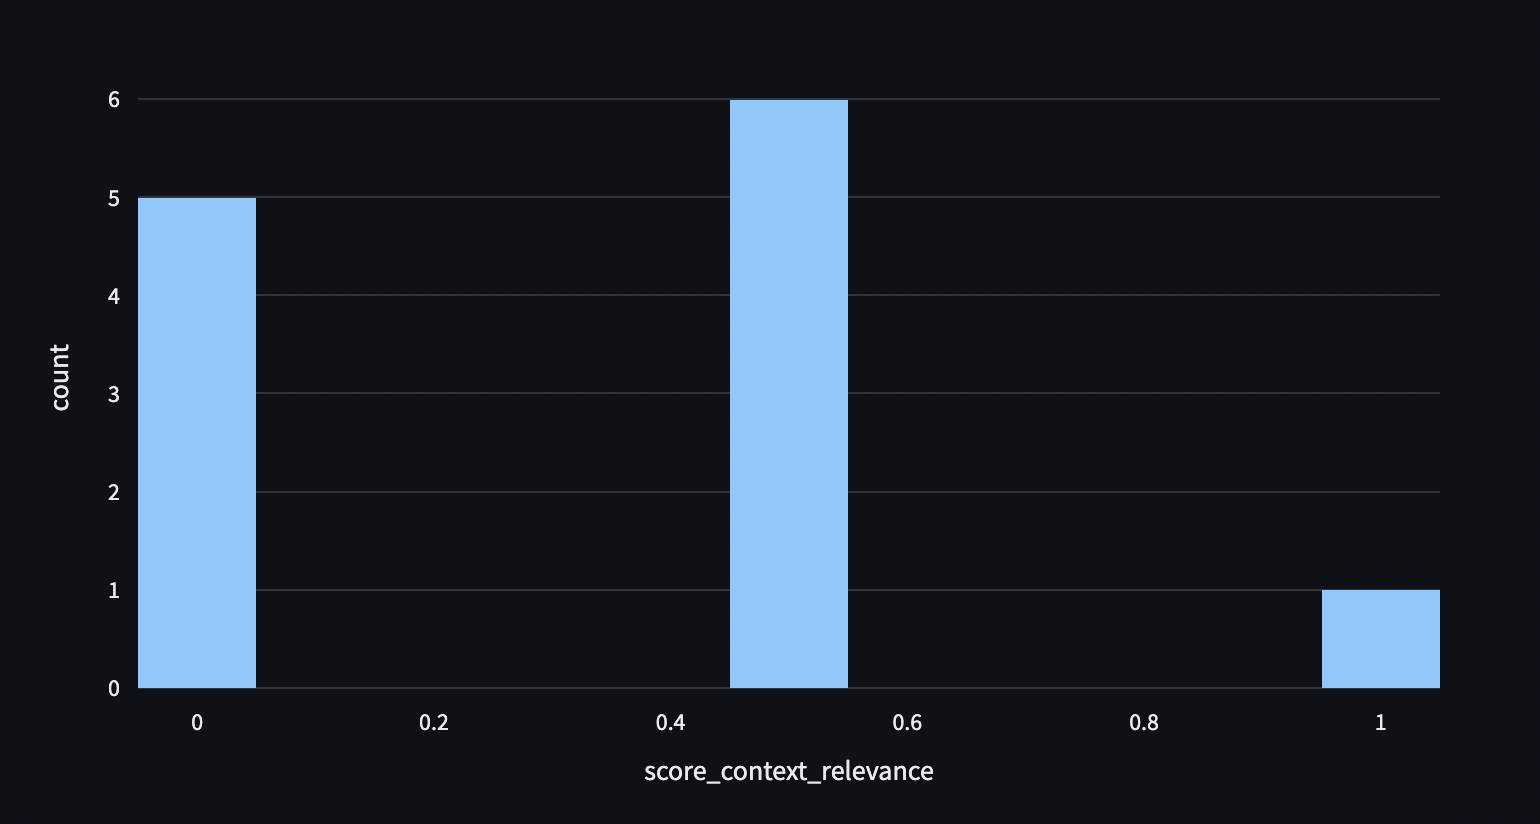

**Running Experiments using UpTrain**: Let's also see how UpTrain can be used to conduct data-driven experimentation. We will increase the chunk_size from 200 to 1000 and see how that impacts the context retrieval quality.

**Generate new embeddings**: We will again use SingleStoreDB to store new document embeddings

In [14]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=0)
all_splits = text_splitter.split_documents(data)
vectorstore_new = SingleStoreDB.from_documents(documents=all_splits,
                                               embedding=OpenAIEmbeddings(),
                                               table_name='vertex_ai_docs_chunk_size_1000')

**Generate responses with new vectorstore**: Let's generate new responses for the same set of questions.

In [15]:
results_larger_chunk = []
for question in questions:
    results_larger_chunk.extend(generate_llm_response(question, vectorstore_new))

**Append chunk size information**: Let's add the corresponding chunk size information for both sets of results. We will pass this column name to UpTrain to compare the two experiments

In [16]:
for x in results:
    x.update({'chunk_size': 200})

for x in results_larger_chunk:
    x.update({'chunk_size': 1000})

**Evaluating Experiments using UpTrain**: UpTrain's APIClient also provides a "evaluate_experiments" method which takes the input data to be evaluated along with the list of checks to be run and the name of the columns associated with the experiment.

In [17]:
eval_client.evaluate_experiments(
    project_name='VertexAI-QnA-Bot-Chunk-Size-Experiments',
    data=results + results_larger_chunk,
    checks=[Evals.CONTEXT_RELEVANCE],
    exp_columns=['chunk_size']
);

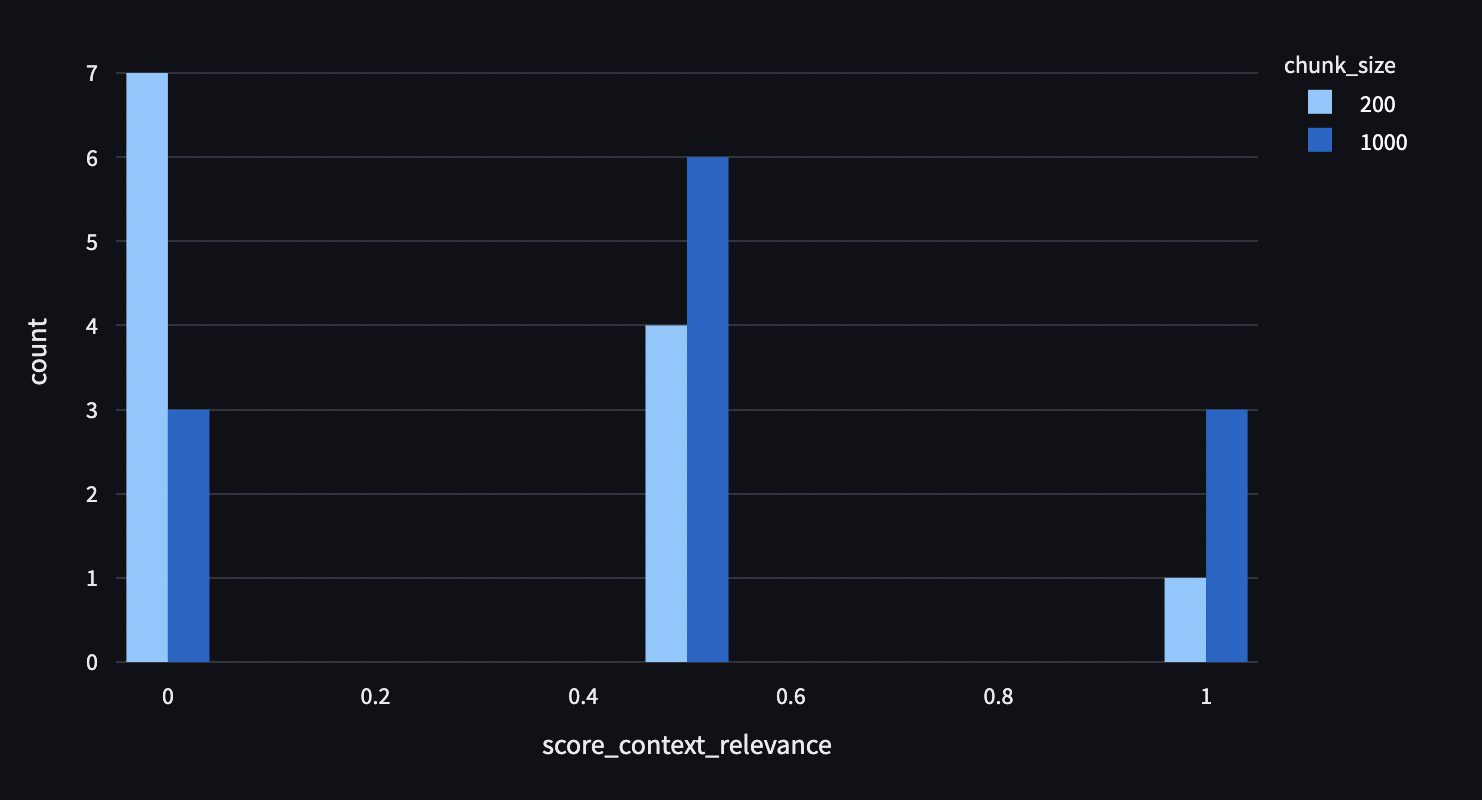

<div id="singlestore-footer" style="background-color: rgba(194, 193, 199, 0.25); height:2px; margin-bottom:10px"></div>
<div><img src="https://raw.githubusercontent.com/singlestore-labs/spaces-notebooks/master/common/images/singlestore-logo-grey.png" style="padding: 0px; margin: 0px; height: 24px"/></div>